# Implementation of Axitra and Qseis

Tests to see if Axitra and Qseis work as expected.

* <a href=#intro>Introduction</a>
* <a href=#example>Example</a>
  * <a href=#example_axitra>Axitra</a>
  * <a href=#example_qseis>Qseis</a>
  * <a href=#example_wrappers>Wrappers</a>
* <a href=#tests>Tests</a>
    * <a href=#tests_explosion>Explosion</a>
    * <a href=#tests_vertical_strike_slip>Vertical strike-slip</a>
    * <a href=#tests_vertical_dip_slip>Vertical dip-slip</a>
* <a href=#greens_functions>Green's functions</a>
    * <a href=#greens_functions_axitra>Axitra</a>
    * <a href=#greens_functions_qseis>Qseis</a>

In [1]:
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = 'all'

## Introduction <a name="intro" />

Both Axitra and Qseis are Fortran codes and are compiled with Microsoft Visual Studio (MVS) 2015 and the Intel Fortran compiler integration (the latter was not available for MVS 2017). In the settings of MVS the 'Project > Properties > Fortran > Data > Default Real Kind' setting had to be changed from 4 to 8, for both programs.

#### Axitra

Axitra is written by Olivier Courant after (Cotton & Coutant, 1997). We downloaded version 2008 from https://www.isterre.fr/annuaire/pages-web-du-personnel/olivier-coutant/article/logiciels-softwares?lang=en (last accessed 2018/02/02). 'Axitra.exe' calculates Green’s functions for six elementary moment tensors (see 'refleft5.f' of the source code). With 'Convm.exe' these can be convolved with a source mechanism and source time function.

We adapted 'convm.f' and 'binaryOut.f' to get the seismograms in text format, instead of binary. In the 'parameters.inc' file the 'ncp' parameter sets the maximum number of layers, because it was only 6 we increased it to 150.

The seismograms are given in x, y, z coordinates. According to the Axitra README x is north, y is east and z is upward. This is the same convention we use. Seismograms can be in displacement, velocity or acceleration. The units are respectively 'm', 'm/s' and 'm/s2' (see 'Convm.exe'). Source and receiver locations are also given in x, y and z coordinates, but here z seems to be downward (i.e. NED coordinates). There is an option to use longitude and latitude, but it seems that Axitra converts these first to x, y and z. It is therefore better to do this ourselves.

Moment tensors are given in Nm (see output of Convm.exe) and NED coordinates (see README). However, Axitra does not take moment tensors as input, but a focal mechanism and moment. There is an option for an explosive source.

#### Qseis

Qseis is written by Rongjiang Wang after (Wang, 1999). We downloaded version 2006 from https://github.com/pyrocko/fomosto-qseis (last accessed 2018/02/02). 'Qseis.exe' calculates Green’s functions for six elementary moment tensors (see the example that comes with the code) that can be convolved with a source mechanism and source time function.

The seismograms are given in z, r, t coordinates. According to the documentation of the example, z is downward, r is radial and t is tangential. We use z as positive upward, so this component must be inverted. Moment tensors in Qseis are given in NED coordinates. A receiver location is given by azimuth and distance. We interpret azimuth as the source-receiver azimuth and not back-azimuth. In the implementation in [Pyrocko](https://pyrocko.org/) it is also called the receiver azimuth.

## Example <a name="example" />


The Axitra code contains an example with both input and output files. The output is in .sac format. According to the README of the example, the source is a step with a duration of 0.1 sec and the output is displacement.

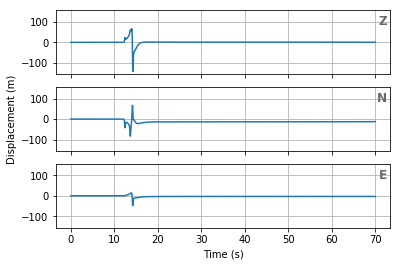

In [3]:
import os

from synthacc.recordings import Recording, read


root_folder = %pwd

tgt_r = Recording({
    'N': read(os.path.join(root_folder, 'data', 'axitra_and_qseis', 'axi001.X.sac'), unit='m', start_time=0),
    'E': read(os.path.join(root_folder, 'data', 'axitra_and_qseis', 'axi001.Y.sac'), unit='m', start_time=0),
    'Z': read(os.path.join(root_folder, 'data', 'axitra_and_qseis', 'axi001.Z.sac'), unit='m', start_time=0),
    })

tgt_r.plot()

### Axitra <a name="example_axitra" />

We create the input files of the example, run Axitra.exe and Convm.exe, and read the output.

In [4]:
from synthacc.ground_models import LayerModel
from synthacc.source.mechanism import FocalMechanism
from synthacc.io import axitra


a_folder = os.path.join('workspaces', 'axitra')
a_params = {'nfreq': 512, 'tl': 70, 'aw': 2, 'xl': 1000000, 'ikmax': 100000}
lgm = LayerModel([1000], [5000], [2886], [2700], [1000], [500])
src = (11130.0196724578, 0, 5000)
rcv = (0, 0, 0)
fm = FocalMechanism(148, 84, -47)
moment = 7.5*10**20
t0 = 10

axitra.write_input(a_folder, a_params, lgm, src, rcv, moment, fm, t0)

In [5]:
%alias Axitra Axitra.exe
%alias Convm (echo 2 & echo 0.1 & echo 1) | Convm

In [6]:
%cd workspaces
%cd axitra

E:\Home\_kris\Python\notebooks\synthacc\workspaces
E:\Home\_kris\Python\notebooks\synthacc\workspaces\axitra


In [7]:
Axitra

 freq           1 /         512
 freq           2 /         512
 freq           3 /         512
 freq           4 /         512
 freq           5 /         512
 freq           6 /         512
 freq           7 /         512
 freq           8 /         512
 freq           9 /         512
 freq          10 /         512
 freq          11 /         512
 freq          12 /         512
 freq          13 /         512
 freq          14 /         512
 freq          15 /         512
 freq          16 /         512
 freq          17 /         512
 freq          18 /         512
 freq          19 /         512
 freq          20 /         512
 freq          21 /         512
 freq          22 /         512
 freq          23 /         512
 freq          24 /         512
 freq          25 /         512
 freq          26 /         512
 freq          27 /         512
 freq          28 /         512
 freq          29 /         512
 freq          30 /         512
 freq          31 /         512
 freq   

In [8]:
Convm

 source function?
 0 : Dirac
 1 : Ricker
 2 : step 
 3 : function stored in file <axi.sou>
 4 : triangle
 5 : ramp
 6 : Haskell (not yet available!)
 7 : True step (watch high frequencies cutoff!!)
 8 : Trapezoid
 source duration?
 output is ?
 1: displacement (m)
 2: velocity (m/s)
 3: acceleration (m/s/s)
 moment (Nm):  7.500000000000000E+020
 moment (Dyne.cm):  7.500000000000000E+027


In [9]:
%cd ..
%cd ..

E:\Home\_kris\Python\notebooks\synthacc\workspaces
E:\Home\_kris\Python\notebooks\synthacc


0.068359375

0

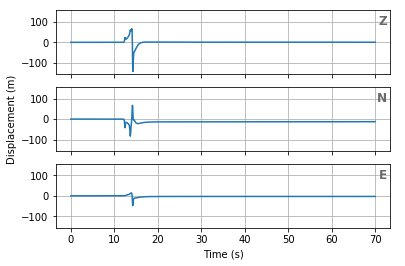

In [10]:
cal_r = axitra.read_recording(a_folder, gmt='dis')
cal_r.time_delta
cal_r.start_time
cal_r.plot()

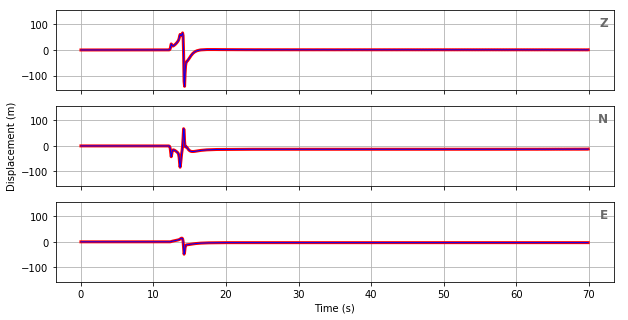

In [11]:
from synthacc.recordings import plot_recordings


plot_recordings([tgt_r, cal_r], colors=['r', 'b'], widths=[3, 1], size=(10, 5))

### Qseis <a name="example_qseis" />

We create the input files of the example, run Qseis.exe and read the output. We get almost an exact match by using a (tapered Heaviside wavelet' with a duration of 6 time samples. With a 'normalized square half-sinusoid' there is no match at all.

In [12]:
import os

import numpy as np

from synthacc.io import qseis


q_folder = os.path.join('workspaces', 'qseis')
filespec = os.path.join(q_folder, 'qseis.dat')
q_params = dict(**qseis.DEFAULT_PARAMS)
q_params.update({'duration': 70, 'nsamples': 512*2, 'stf_type': 2, 'stf_nsamples': 6})
lgm = LayerModel([50000], [5000], [2886], [2700], [1000], [500]) ## ticker layer to avoid reflections
cgm = lgm.to_continuous_model()
src_depth = src[-1]
distances = [src[0]]
rcv_depth = rcv[-1]
mt = fm.get_moment_tensor(moment)
azimuths = [180]

qseis.write_input(filespec, q_params, cgm, src_depth, distances, rcv_depth, mt, azimuths)

In [13]:
%alias Qseis (echo qseis.dat) | Qseis

In [14]:
%cd workspaces
%cd qseis

E:\Home\_kris\Python\notebooks\synthacc\workspaces
E:\Home\_kris\Python\notebooks\synthacc\workspaces\qseis


In [15]:
Qseis

The system cannot execute the specified program.


In [16]:
% cd ..
% cd ..

C:\Users\Bart Vleminckx\OneDrive\Work\Transfer\Notebooks\workspaces
C:\Users\Bart Vleminckx\OneDrive\Work\Transfer\Notebooks


0.06843

10

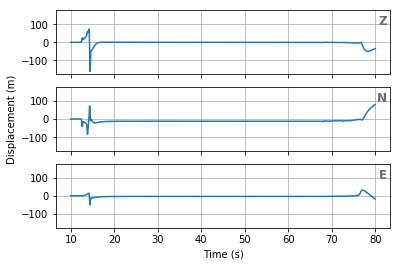

In [17]:
[cal_r] = qseis.read_recordings(q_folder)
cal_r = cal_r.rotate(back_azimuth=0)
cal_r.start_time = t0
cal_r.time_delta
cal_r.start_time
cal_r.plot()

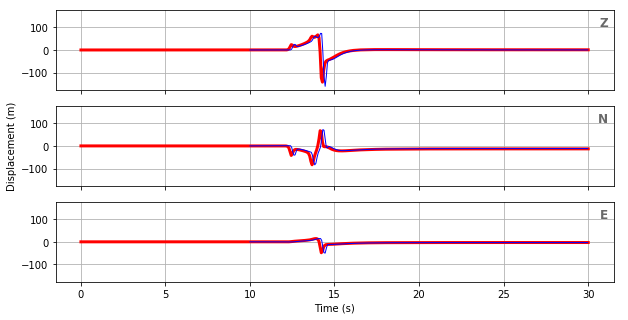

In [18]:
plot_recordings([tgt_r, cal_r], colors=['r', 'b'], widths=[3, 1], size=(10, 5), e_time=30)

### Wrappers <a name="example_wrappers" />

0.068359375


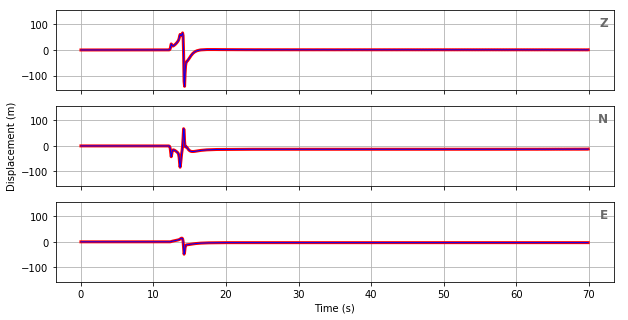

In [19]:
w = axitra.Wrapper(a_folder, nfreqs=a_params['nfreq'], duration=a_params['tl'], ground_model=lgm)

stf = (2, 0.1)

cal_r = w.get_recording(src, rcv, moment, fm, stf, 'dis', t0)
print(cal_r.time_delta)

plot_recordings([tgt_r, cal_r], colors=['r', 'b'], widths=[3, 1], size=(10, 5))

0.06843


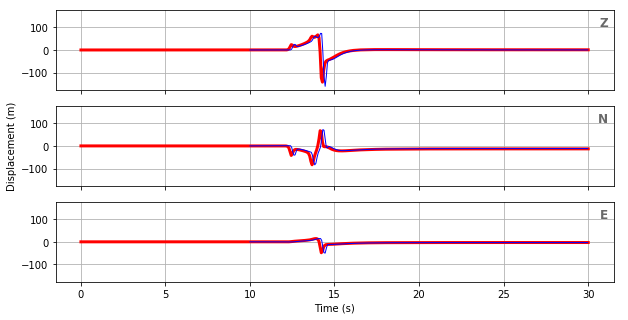

In [20]:
w = qseis.Wrapper(q_folder, nsamps=1024, duration=70, ground_model=cgm, params={'stf_type': 2, 'stf_nsamples': 6})

cal_r = w.get_recording(src, rcv, mt)
print(cal_r.time_delta)
cal_r.start_time = t0

plot_recordings([tgt_r, cal_r], colors=['r', 'b'], widths=[3, 1], size=(10, 5), e_time=30)

## Convolution <a name="convolution" />

No source

14.628571428571428


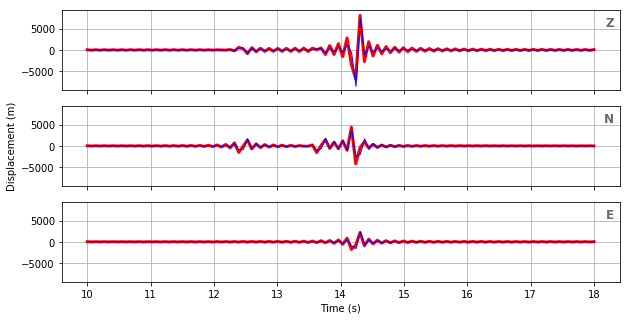

In [21]:
w = axitra.Wrapper(a_folder, nfreqs=a_params['nfreq'], duration=a_params['tl'], ground_model=lgm)
a_r = w.get_recording(src, rcv, moment, fm, None, 'dis', t0)

w = qseis.Wrapper(q_folder, nsamps=1024, duration=70, ground_model=cgm, params={'stf_type': 1, 'stf_nsamples': 1})
q_r = w.get_recording(src, rcv, mt)
q_r.start_time = t0
print(1/a_r.time_delta)

plot_recordings([a_r, q_r], colors=['r', 'b'], widths=[3, 1], size=(10, 5), s_time=10, e_time=18)

## Tests <a name="tests" />

Source at a depth of 5000 m. Receiver 5000 m north of source.

In [22]:
src = (0, 0, 5000)
rcv = (5000, 0, 0)

distance = float(np.sqrt((rcv[0]-src[0])**2+(rcv[1]-src[1])**2+(rcv[2]-src[2])**2))
distance

lgm = LayerModel([20000], [5800], [3200], [2600], [925], [600]) ## Top layer of the ak135f model
cgm = lgm.to_continuous_model()

7071.067811865475

## Explosion <a name="tests_explosion" />

We expect a P-wave on the Z and E components with positive polarity.

In [23]:
from synthacc.source.moment import MomentTensor


fm = None
mt = MomentTensor(1, 1, 1, 0, 0, 0)

In [24]:
w = axitra.Wrapper(a_folder, nfreqs=a_params['nfreq'], duration=30, ground_model=lgm)
a_rec = w.get_recording(src, rcv, mt.moment)

In [25]:
w = qseis.Wrapper(q_folder, nsamps=1024, duration=30, ground_model=cgm, params={'stf_type': 1, 'stf_nsamples': 1})
q_rec = w.get_recording(src, rcv, mt)

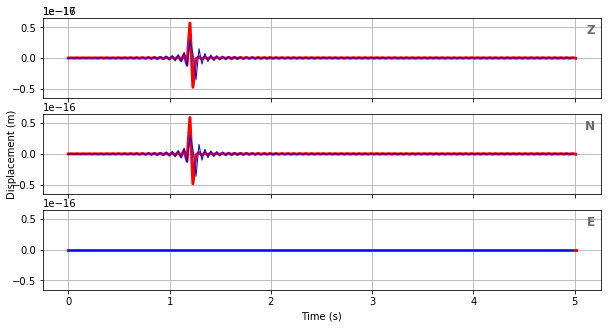

In [26]:
plot_recordings([a_rec, q_rec], colors=['r', 'b'], widths=[3, 1], size=(10, 5), e_time=5)

## Test - Vertical strike-slip <a name="test_vertical_strike_slip" />

Strike is 90, dip is 90 and rake is 0. We expect only a S-wave on the E-W component with positive polarity.

In [27]:
fm = FocalMechanism(90, 90, 0)
moment = 1
mt = fm.get_moment_tensor(moment)
print(mt)

< Moment Tensor | 0 0 0 -1 0 0 >


In [28]:
w = axitra.Wrapper(a_folder, nfreqs=a_params['nfreq'], duration=30, ground_model=lgm)
a_rec = w.get_recording(src, rcv, mt.moment, fm)

In [29]:
w = qseis.Wrapper(q_folder, nsamps=1024, duration=30, ground_model=cgm, params={'stf_type': 1, 'stf_nsamples': 1})
q_rec = w.get_recording(src, rcv, mt)

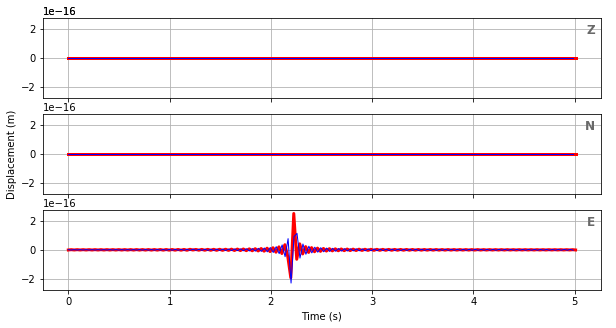

In [30]:
plot_recordings([a_rec, q_rec], colors=['r', 'b'], widths=[3, 1], size=(10, 5), e_time=5)

## Test - Vertical dip-slip <a name="test_vertical_dip_slip" />

Strike is 90, dip is 90 and rake is -90. We expect a P-wave on the Z and N components with positive polarity.

In [31]:
fm = FocalMechanism(90, 90, -90)
moment = 1
mt = fm.get_moment_tensor(moment)
mt

< Moment Tensor | 0 0 0 0 0 -1 >

In [32]:
w = axitra.Wrapper(a_folder, nfreqs=a_params['nfreq'], duration=30, ground_model=lgm)
a_rec = w.get_recording(src, rcv, mt.moment, fm)

In [33]:
w = qseis.Wrapper(q_folder, nsamps=1024, duration=30, ground_model=cgm, params={'stf_type': 1, 'stf_nsamples': 1})
q_rec = w.get_recording(src, rcv, mt)

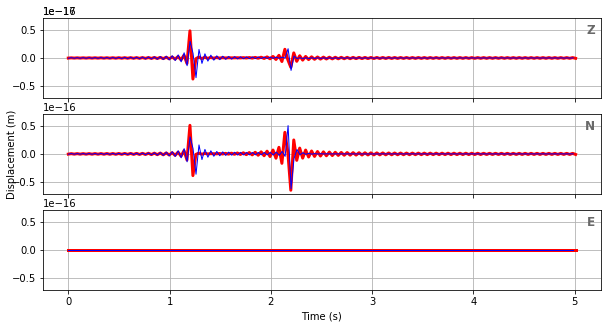

In [34]:
plot_recordings([a_rec, q_rec], colors=['r', 'b'], widths=[3, 1], size=(10, 5), e_time=5)

## Green's functions <a name="greens_functions" />

Which Green's functions do Axitra en Qseis return?

In [35]:
moment = 1

### Axitra  <a name="greens_functions_axitra" />

Moment tensors for the six Green's fucntions of Axitra (see 'refleft5.f' of the source code).

```
m1 = ( 0  0  0  1  0  0)
m2 = ( 0  0  0  0  0  1)
m3 = ( 0  0  0  0 -1  0)
m4 = (-1  0  1  0  0  0)
m5 = ( 0 -1 -1  0  0  0)
m6 = ( 1  1  1  0  0  0)
```

In [36]:
fm1 = FocalMechanism(0, 90, 0)
fm2 = FocalMechanism(90, 90, 90)
fm3 = FocalMechanism(0, 90, 90)
fm4 = FocalMechanism(90, 45, 90)
fm5 = FocalMechanism(0, 45, 90)
fm6 = None

m1 = fm1.get_moment_tensor(1)
m2 = fm2.get_moment_tensor(1)
m3 = fm3.get_moment_tensor(1)
m4 = fm4.get_moment_tensor(1)
m5 = fm5.get_moment_tensor(1)
m6 = MomentTensor(1, 1, 1, 0, 0, 0)

print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)

< Moment Tensor | 0 0 0 1 0 0 >
< Moment Tensor | 0 0 0 0 0 1 >
< Moment Tensor | 0 0 0 0 -1 0 >
< Moment Tensor | -1 0 1 0 0 0 >
< Moment Tensor | 0 -1 1 0 0 0 >
< Moment Tensor | 1 1 1 0 0 0 >


In [37]:
w = axitra.Wrapper(a_folder, nfreqs=256, duration=15, ground_model=lgm)

tgt_r_m1 = w.get_recording(src, rcv, moment, fm1)
tgt_r_m2 = w.get_recording(src, rcv, moment, fm2)
tgt_r_m3 = w.get_recording(src, rcv, moment, fm3)
tgt_r_m4 = w.get_recording(src, rcv, moment, fm4)
tgt_r_m5 = w.get_recording(src, rcv, moment, fm5)
tgt_r_m6 = w.get_recording(src, rcv, moment, fm6)

tgt_r_m6.time_delta

0.029296875

In [38]:
from synthacc.io.axitra import read_head, read_res


frequencies = read_head(os.path.join(a_folder, 'axi.head'))

time_delta = float(1 / (frequencies[1] * len(frequencies) * 2))
time_delta

gfs = np.fft.irfft(read_res(os.path.join(a_folder, 'axi.res'), 1, 1, len(frequencies)) / time_delta, axis=0)

gfs.shape

0.029296875

(510, 1, 1, 3, 6)

In [39]:
from synthacc.recordings import Seismogram


n = 1

cal_r_m1 = Recording({
    'N': Seismogram(time_delta, np.convolve(gfs[:,0,0,0,0], np.ones(n)/(time_delta*n)) * time_delta, unit='m'),
    'E': Seismogram(time_delta, np.convolve(gfs[:,0,0,1,0], np.ones(n)/(time_delta*n)) * time_delta, unit='m'),
    'Z': Seismogram(time_delta, np.convolve(gfs[:,0,0,2,0], np.ones(n)/(time_delta*n)) * time_delta, unit='m'),
})
cal_r_m2 = Recording({
    'N': Seismogram(time_delta, gfs[:,0,0,0,1], unit='m'),
    'E': Seismogram(time_delta, gfs[:,0,0,1,1], unit='m'),
    'Z': Seismogram(time_delta, gfs[:,0,0,2,1], unit='m'),
})
cal_r_m3 = Recording({
    'N': Seismogram(time_delta, gfs[:,0,0,0,2], unit='m'),
    'E': Seismogram(time_delta, gfs[:,0,0,1,2], unit='m'),
    'Z': Seismogram(time_delta, gfs[:,0,0,2,2], unit='m'),
})
cal_r_m4 = Recording({
    'N': Seismogram(time_delta, gfs[:,0,0,0,3], unit='m'),
    'E': Seismogram(time_delta, gfs[:,0,0,1,3], unit='m'),
    'Z': Seismogram(time_delta, gfs[:,0,0,2,3], unit='m'),
})
cal_r_m5 = Recording({
    'N': Seismogram(time_delta, gfs[:,0,0,0,4], unit='m'),
    'E': Seismogram(time_delta, gfs[:,0,0,1,4], unit='m'),
    'Z': Seismogram(time_delta, gfs[:,0,0,2,4], unit='m'),
})
cal_r_m6 = Recording({
    'N': Seismogram(time_delta, gfs[:,0,0,0,5], unit='m'),
    'E': Seismogram(time_delta, gfs[:,0,0,1,5], unit='m'),
    'Z': Seismogram(time_delta, gfs[:,0,0,2,5], unit='m'),
})

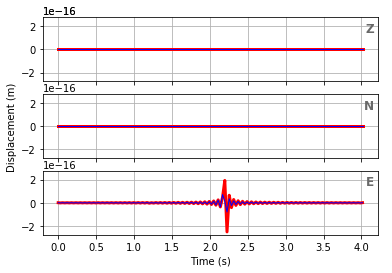

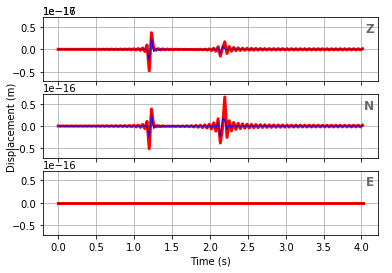

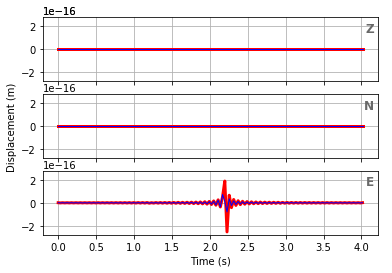

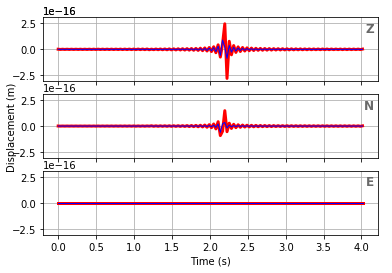

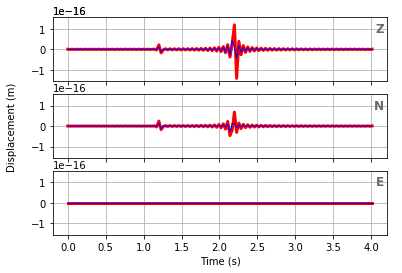

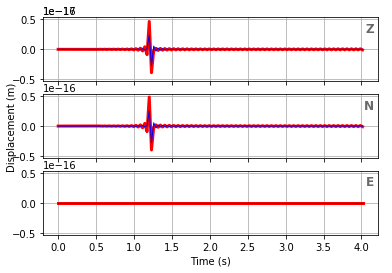

In [40]:
plot_recordings([tgt_r_m1, cal_r_m1], colors=['r', 'b'], widths=[3, 1], e_time=4)
plot_recordings([tgt_r_m2, cal_r_m2], colors=['r', 'b'], widths=[3, 1], e_time=4)
plot_recordings([tgt_r_m3, cal_r_m3], colors=['r', 'b'], widths=[3, 1], e_time=4)
plot_recordings([tgt_r_m4, cal_r_m4], colors=['r', 'b'], widths=[3, 1], e_time=4)
plot_recordings([tgt_r_m5, cal_r_m5], colors=['r', 'b'], widths=[3, 1], e_time=4)
plot_recordings([tgt_r_m6, cal_r_m6], colors=['r', 'b'], widths=[3, 1], e_time=4)

## Qseis <a name="greens_functions_qseis" />

Moment tensors for the six Green's fucntions of Qseis (see the example that comes with the code).

```
m1 = ( 0  0  0  1  0  0)
m2 = ( 1 -1  0  0  0  0)
m3 = ( 0  0  0  0  0  1)
m4 = ( 0  0  0  0  1  0)
m5 = (-0.5 -0.5 1 0 0 0)
m6 = ( 1  1  1  0  0  0)
```

In [41]:
mt1 = MomentTensor(1, -1, 0, 0, 0, 0)
mt2 = MomentTensor(0, 0, 0, 1, 0, 0)
mt3 = MomentTensor(0, 0, 0, 0, 0, 1)
mt4 = MomentTensor(0, 0, 0, 0, 1, 0)
mt5 = MomentTensor(-0.5, -0.5, 1, 0, 0, 0)
mt6 = MomentTensor(1, 1, 1, 0, 0, 0)

print(mt1)
print(mt2)
print(mt3)
print(mt4)
print(mt5)
print(mt6)

< Moment Tensor | 1 -1 0 0 0 0 >
< Moment Tensor | 0 0 0 1 0 0 >
< Moment Tensor | 0 0 0 0 0 1 >
< Moment Tensor | 0 0 0 0 1 0 >
< Moment Tensor | -0.5 -0.5 1 0 0 0 >
< Moment Tensor | 1 1 1 0 0 0 >


In [42]:
w = qseis.Wrapper(q_folder, nsamps=512, duration=15, ground_model=cgm)

rcv = (5000, 0, 0)

tgt_r_mt1 = w.get_recording(src, rcv, mt1, components='ZRT')
tgt_r_mt2 = w.get_recording(src, rcv, mt2, components='ZRT')
tgt_r_mt3 = w.get_recording(src, rcv, mt3, components='ZRT')
tgt_r_mt4 = w.get_recording(src, rcv, mt4, components='ZRT')
tgt_r_mt5 = w.get_recording(src, rcv, mt5, components='ZRT')
tgt_r_mt6 = w.get_recording(src, rcv, mt6, components='ZRT')

In [43]:
from synthacc.io.qseis import read_gf


time_delta, stack = read_gf(q_folder)

zss = Seismogram(time_delta, stack[0,:,0], unit='m') *-1
rss = Seismogram(time_delta, stack[0,:,1], unit='m')
tss = Seismogram(time_delta, stack[0,:,2], unit='m')
zds = Seismogram(time_delta, stack[0,:,3], unit='m') *-1
rds = Seismogram(time_delta, stack[0,:,4], unit='m')
tds = Seismogram(time_delta, stack[0,:,5], unit='m') *-1
zcl = Seismogram(time_delta, stack[0,:,6], unit='m') *-1
rcl = Seismogram(time_delta, stack[0,:,7], unit='m')
zex = Seismogram(time_delta, stack[0,:,8], unit='m') *-1
rex = Seismogram(time_delta, stack[0,:,9], unit='m')

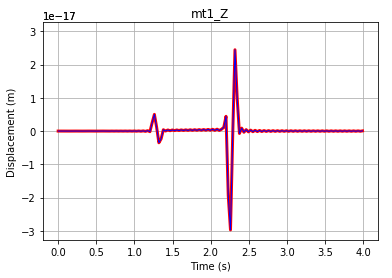

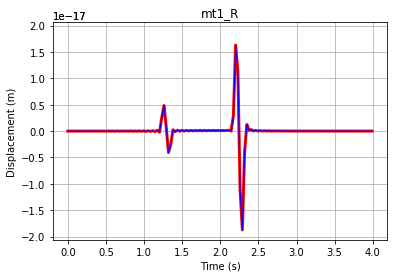

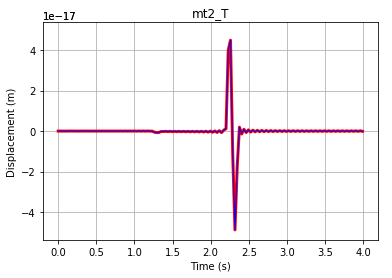

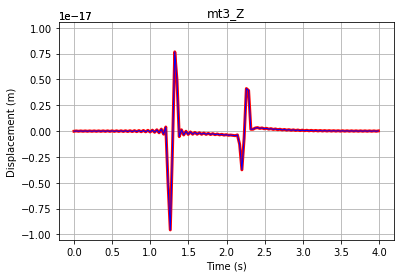

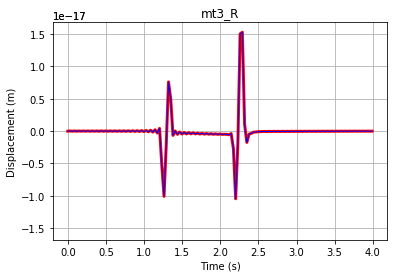

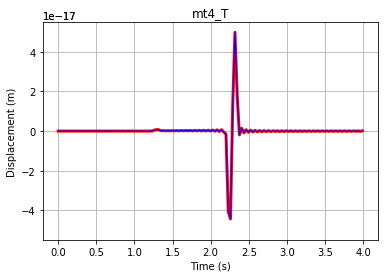

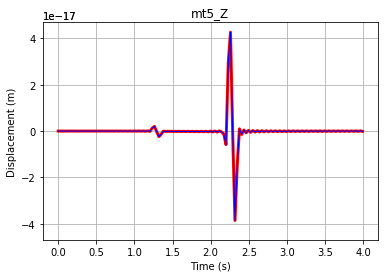

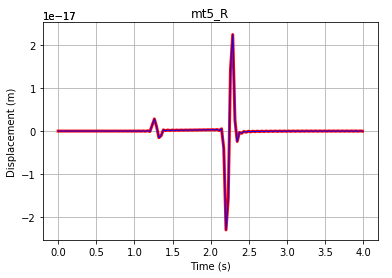

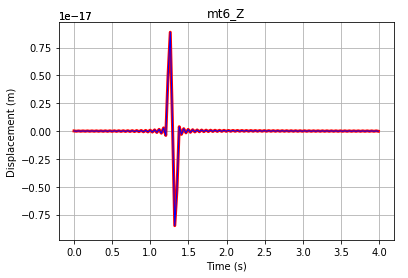

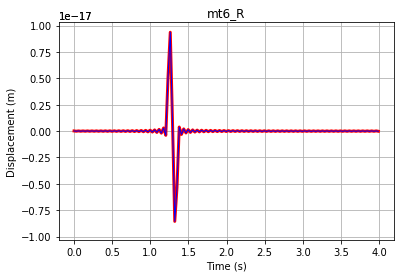

In [44]:
from synthacc.recordings import plot_seismograms


plot_seismograms([[tgt_r_mt1.get_component('Z'), zss]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt1_Z')
plot_seismograms([[tgt_r_mt1.get_component('R'), rss]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt1_R')
plot_seismograms([[tgt_r_mt2.get_component('T'), tss]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt2_T')
plot_seismograms([[tgt_r_mt3.get_component('Z'), zds]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt3_Z')
plot_seismograms([[tgt_r_mt3.get_component('R'), rds]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt3_R')
plot_seismograms([[tgt_r_mt4.get_component('T'), tds]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt4_T')
plot_seismograms([[tgt_r_mt5.get_component('Z'), zcl]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt5_Z')
plot_seismograms([[tgt_r_mt5.get_component('R'), rcl]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt5_R')
plot_seismograms([[tgt_r_mt6.get_component('Z'), zex]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt6_Z')
plot_seismograms([[tgt_r_mt6.get_component('R'), rex]], colors=[['r', 'b']], widths=[[3, 1]], e_time=4, title='mt6_R')